# 04 - Allen2022 fMRI Benchmark Smoke Test (Surface)

Score AlexNet on both the **8-subject** (515 images) and **4-subject** (~1000 images)
fsaverage surface fMRI benchmarks.

**Sections:**
1. Load and verify assemblies (both variants)
2. Compare with volumetric assemblies
3. Verify benchmark registration (16 benchmarks)
4. Score AlexNet (ridge + RSA, both variants)
5. Assembly visualizations
6. Summary

Registry identifiers:
- `Allen2022_fmri_surface.{V1,V2,V4,IT}-{ridge,rdm}` -- 8-subject
- `Allen2022_fmri_surface_4subj.{V1,V2,V4,IT}-{ridge,rdm}` -- 4-subject

**Environment:** `conda activate vision-2026`

In [2]:
import sys
sys.path.insert(0, '/Users/kartik/Brain-Score 2026/vision')
sys.path.insert(0, '/Users/kartik/Brain-Score 2026/core')

import time
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path

from brainscore_vision import load_model, load_benchmark

SURFACE_DIR = Path('/Volumes/Hagibis/nsd/brainscore_surface')
VOL_DIR = Path('/Volumes/Hagibis/nsd/brainscore')
REGIONS = ['V1', 'V2', 'V4', 'IT']
VARIANTS = {'8-subject': '_8subj', '4-subject': '_4subj'}
BENCHMARK_PREFIXES = {
    '8-subject': 'Allen2022_fmri_surface',
    '4-subject': 'Allen2022_fmri_surface_4subj',
}

/Users/kartik/Brain-Score 2026/core/brainscore_core/metrics/__init__.py:16: FutureWarning: xarray subclass Score should explicitly define __slots__
  class Score(DataAssembly):


## 1. Load and Verify Assemblies

In [3]:
assemblies = {}
for label, suffix in VARIANTS.items():
    train = xr.open_dataarray(str(SURFACE_DIR / f'Allen2022_fmri_surface_train{suffix}.nc'))
    train.load()
    test = xr.open_dataarray(str(SURFACE_DIR / f'Allen2022_fmri_surface_test{suffix}.nc'))
    test.load()
    assemblies[label] = {'train': train, 'test': test}

print('Surface Assembly Comparison')
print('=' * 70)
print(f'{"Property":<30s}  {"8-Subject":>15s}  {"4-Subject":>15s}')
print('-' * 70)

for prop, fn in [
    ('Subjects', lambda v: len(np.unique(assemblies[v]['train'].coords['subject'].values))),
    ('Train shape', lambda v: str(assemblies[v]['train'].shape)),
    ('Test shape', lambda v: str(assemblies[v]['test'].shape)),
    ('Train images', lambda v: assemblies[v]['train'].sizes['presentation']),
    ('Test images (unique)', lambda v: len(set(assemblies[v]['test'].coords['stimulus_id'].values))),
    ('Total neuroids', lambda v: assemblies[v]['train'].sizes['neuroid']),
]:
    v8 = fn('8-subject')
    v4 = fn('4-subject')
    print(f'{prop:<30s}  {str(v8):>15s}  {str(v4):>15s}')

# Verify no train/test overlap
for label in VARIANTS:
    train_stims = set(assemblies[label]['train'].coords['stimulus_id'].values)
    test_stims = set(assemblies[label]['test'].coords['stimulus_id'].values)
    assert len(train_stims & test_stims) == 0, f'{label}: train/test overlap!'
    total = len(train_stims | test_stims)
    print(f'\n{label}: train/test overlap=0 (verified), total images={total}')

Surface Assembly Comparison
Property                              8-Subject        4-Subject
----------------------------------------------------------------------
Subjects                                      8                4
Train shape                     (412, 221168, 1)  (800, 110584, 1)
Test shape                      (309, 221168, 1)  (600, 110584, 1)
Train images                                412              800
Test images (unique)                        103              200
Total neuroids                           221168           110584

8-subject: train/test overlap=0 (verified), total images=515

4-subject: train/test overlap=0 (verified), total images=1000


In [4]:
train_8s = assemblies['8-subject']['train']
train_4s = assemblies['4-subject']['train']

print('Per-region neuroid counts and noise ceilings')
print(f'{"Region":>6s}  {"8s Neuroids":>12s}  {"4s Neuroids":>12s}  '
      f'{"8s NC":>7s}  {"4s NC":>7s}  {"8s Reliable":>12s}  {"4s Reliable":>12s}')
print('-' * 85)

for region in REGIONS:
    mask_8 = train_8s.coords['region'].values == region
    mask_4 = train_4s.coords['region'].values == region
    n8, n4 = mask_8.sum(), mask_4.sum()
    nc8 = train_8s.coords['nc_testset'].values[mask_8]
    nc4 = train_4s.coords['nc_testset'].values[mask_4]
    r8, r4 = (nc8 > 30).sum(), (nc4 > 30).sum()
    print(f'{region:>6s}  {n8:>12,}  {n4:>12,}  '
          f'{np.nanmedian(nc8):>6.1f}%  {np.nanmedian(nc4):>6.1f}%  '
          f'{r8:>12,}  {r4:>12,}')

Per-region neuroid counts and noise ceilings
Region   8s Neuroids   4s Neuroids    8s NC    4s NC   8s Reliable   4s Reliable
-------------------------------------------------------------------------------------
    V1        34,208        17,104    34.5%    39.1%        18,542         9,778
    V2        27,128        13,564    35.9%    39.2%        15,351         8,081
    V4         7,312         3,656    45.2%    51.7%         5,782         3,078
    IT       152,520        76,260    18.6%    20.6%        52,451        28,714


## 2. Compare with Volumetric Assemblies

In [5]:
vol_assemblies = {}
for label, suffix in VARIANTS.items():
    vt = xr.open_dataarray(str(VOL_DIR / f'Allen2022_fmri_train{suffix}.nc'))
    vt.load()
    vol_assemblies[label] = vt

print('Comparison: Surface vs Volumetric assemblies')
print('=' * 75)

for label in VARIANTS:
    surf_train = assemblies[label]['train']
    vol_train = vol_assemblies[label]
    print(f'\n--- {label} ---')
    print(f'  Surface train: {surf_train.shape}')
    print(f'  Volumetric train: {vol_train.shape}')

print(f'\n{"Region":>6s}  {"8s Surf":>9s}  {"8s Vol":>8s}  '
      f'{"4s Surf":>9s}  {"4s Vol":>8s}  '
      f'{"8s Surf NC":>10s}  {"8s Vol NC":>9s}')
print('-' * 75)

for region in REGIONS:
    s8_mask = train_8s.coords['region'].values == region
    v8_mask = vol_assemblies['8-subject'].coords['region'].values == region
    s4_mask = train_4s.coords['region'].values == region
    v4_mask = vol_assemblies['4-subject'].coords['region'].values == region
    s8_nc = np.nanmedian(train_8s.coords['nc_testset'].values[s8_mask])
    v8_nc = np.nanmedian(vol_assemblies['8-subject'].coords['nc_testset'].values[v8_mask])
    print(f'{region:>6s}  {s8_mask.sum():>9,}  {v8_mask.sum():>8,}  '
          f'{s4_mask.sum():>9,}  {v4_mask.sum():>8,}  '
          f'{s8_nc:>9.1f}%  {v8_nc:>8.1f}%')

for v in vol_assemblies.values():
    v.close()
del vol_assemblies

Comparison: Surface vs Volumetric assemblies

--- 8-subject ---
  Surface train: (412, 221168, 1)
  Volumetric train: (412, 84564, 1)

--- 4-subject ---
  Surface train: (800, 110584, 1)
  Volumetric train: (800, 40314, 1)

Region    8s Surf    8s Vol    4s Surf    4s Vol  8s Surf NC  8s Vol NC
---------------------------------------------------------------------------
    V1     34,208     9,039     17,104     4,707       34.5%      37.4%
    V2     27,128     8,792     13,564     4,575       35.9%      31.2%
    V4      7,312     3,982      3,656     2,109       45.2%      25.3%
    IT    152,520    62,751     76,260    28,923       18.6%       7.8%


## 3. Verify Benchmark Registration

In [6]:
import brainscore_vision.benchmarks.allen2022_fmri_surface
from brainscore_vision import benchmark_registry

for label, prefix in BENCHMARK_PREFIXES.items():
    print(f'{label} benchmarks:')
    for region in REGIONS:
        for metric in ['ridge', 'rdm']:
            key = f'{prefix}.{region}-{metric}'
            assert key in benchmark_registry, f'{key} not registered!'
            print(f'  {key}: registered')
    print()

n_surface = sum(1 for k in benchmark_registry if k.startswith('Allen2022_fmri_surface'))
print(f'Total Allen2022_fmri_surface benchmarks registered: {n_surface}')

8-subject benchmarks:
  Allen2022_fmri_surface.V1-ridge: registered
  Allen2022_fmri_surface.V1-rdm: registered
  Allen2022_fmri_surface.V2-ridge: registered
  Allen2022_fmri_surface.V2-rdm: registered
  Allen2022_fmri_surface.V4-ridge: registered
  Allen2022_fmri_surface.V4-rdm: registered
  Allen2022_fmri_surface.IT-ridge: registered
  Allen2022_fmri_surface.IT-rdm: registered

4-subject benchmarks:
  Allen2022_fmri_surface_4subj.V1-ridge: registered
  Allen2022_fmri_surface_4subj.V1-rdm: registered
  Allen2022_fmri_surface_4subj.V2-ridge: registered
  Allen2022_fmri_surface_4subj.V2-rdm: registered
  Allen2022_fmri_surface_4subj.V4-ridge: registered
  Allen2022_fmri_surface_4subj.V4-rdm: registered
  Allen2022_fmri_surface_4subj.IT-ridge: registered
  Allen2022_fmri_surface_4subj.IT-rdm: registered

Total Allen2022_fmri_surface benchmarks registered: 16


## 4. Score AlexNet

Score all 16 surface benchmarks: 4 regions x 2 metrics x 2 subject variants.

In [7]:
model = load_model('alexnet')

METRICS = ['ridge', 'rdm']
results = []

for label, prefix in BENCHMARK_PREFIXES.items():
    for region in REGIONS:
        for metric in METRICS:
            benchmark_id = f'{prefix}.{region}-{metric}'
            print(f'Scoring {benchmark_id}...', end=' ', flush=True)
            t0 = time.time()
            benchmark = load_benchmark(benchmark_id)
            score = benchmark(model)
            elapsed = time.time() - t0
            results.append({
                'benchmark': benchmark_id,
                'variant': label,
                'region': region,
                'metric': metric,
                'raw': float(score.raw),
                'ceiling': float(score.ceiling),
                'normalized': float(score),
            })
            print(f'norm={float(score):.4f}  raw={float(score.raw):.4f}  '
                  f'ceil={float(score.ceiling):.4f}  ({elapsed:.1f}s)')

results_df = pd.DataFrame(results)
print(f'\nScored {len(results_df)} benchmarks.')

/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Scoring Allen2022_fmri_surface.V1-ridge... 

/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 2.6690113230642964e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.45197024])
Coordinates:
  * subject  (subject) <U6 'subj01'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.5132535], dtype=float32)\...
    ceiling:  <xarray.Score ()>\narray(0.58284626)\nAttributes:\n    raw:    ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 2.6690113230642964e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.48772174])
Coordinates:
  * subject  (subject) <U6 'subj02'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.5650202], dtype=float32)\...
    ceiling:  <xarray.Score ()>\narray(0.65456961)\nAttributes:\n    raw:    ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 2.6690113230642964e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.47932531])
Coordinates:
  * subject  (subject) <U6 'subj03'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.47005734], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.46096857)\nAttributes:\n    raw:    ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 2.6690113230642964e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.4234262])
Coordinates:
  * subject  (subject) <U6 'subj04'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.45018864], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.47864257)\nAttributes:\n    raw:    ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 2.6690113230642964e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.28405508])
Coordinates:
  * subject  (subject) <U6 'subj05'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.38278347], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.51582667)\nAttributes:\n    raw:    ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 2.6690113230642964e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.28386699])
Coordinates:
  * subject  (subject) <U6 'subj06'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.35936436], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.45494103)\nAttributes:\n    raw:    ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 2.6690113230642964e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.45459834])
Coordinates:
  * subject  (subject) <U6 'subj07'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.4958582], dtype=float32)\...
    ceiling:  <xarray.Score ()>\narray(0.54086283)\nAttributes:\n    raw:    ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 2.6690113230642964e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.43785964])
Coordinates:
  * subject  (subject) <U6 'subj08'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.44765043], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.45766015)\nAttributes:\n    raw:    ...
norm=0.4129  raw=0.4605  ceil=0.5146  (15.6s)
Scoring Allen2022_fmri_surface.V1-rdm... 

/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


activations:   0%|          | 0/576 [00:00<?, ?it/s]

layer packaging:   0%|          | 0/1 [00:00<?, ?it/s]

norm=0.4501  raw=0.2310  ceil=0.5131  (8.3s)
Scoring Allen2022_fmri_surface.V2-ridge... 

/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 9.928403699177579e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.47012078])
Coordinates:
  * subject  (subject) <U6 'subj01'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.51486695], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.56387206)\nAttributes:\n    raw:    ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 9.928403699177579e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.4242739])
Coordinates:
  * subject  (subject) <U6 'subj02'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.49792504], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.58436154)\nAttributes:\n    raw:    ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 9.928403699177579e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.42771601])
Coordinates:
  * subject  (subject) <U6 'subj03'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.43621886], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.44489074)\nAttributes:\n    raw:    ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 9.928403699177579e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.49107506])
Coordinates:
  * subject  (subject) <U6 'subj04'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.4863616], dtype=float32)\...
    ceiling:  <xarray.Score ()>\narray(0.48169337)\nAttributes:\n    raw:    ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 9.928403699177579e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.33716065])
Coordinates:
  * subject  (subject) <U6 'subj05'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.40352675], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.48295625)\nAttributes:\n    raw:    ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 9.928403699177579e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.41165294])
Coordinates:
  * subject  (subject) <U6 'subj06'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.43898764], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.46813743)\nAttributes:\n    raw:    ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 9.928403699177579e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.48057205])
Coordinates:
  * subject  (subject) <U6 'subj07'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.48259515], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.48462676)\nAttributes:\n    raw:    ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 9.928403699177579e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.48453049])
Coordinates:
  * subject  (subject) <U6 'subj08'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.48860618], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.49271616)\nAttributes:\n    raw:    ...
norm=0.4409  raw=0.4686  ceil=0.5002  (15.1s)
Scoring Allen2022_fmri_surface.V2-rdm... 

/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


norm=0.3790  raw=0.1843  ceil=0.4863  (4.6s)
Scoring Allen2022_fmri_surface.V4-ridge... 

/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 9.928403699177579e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.44368672])
Coordinates:
  * subject  (subject) <U6 'subj01'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.47483057], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.5081605)\nAttributes:\n    raw:     ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 9.928403699177579e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.48174151])
Coordinates:
  * subject  (subject) <U6 'subj02'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.5506409], dtype=float32)\...
    ceiling:  <xarray.Score ()>\narray(0.62939434)\nAttributes:\n    raw:    ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 9.928403699177579e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.44947871])
Coordinates:
  * subject  (subject) <U6 'subj03'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.4437025], dtype=float32)\...
    ceiling:  <xarray.Score ()>\narray(0.4380005)\nAttributes:\n    raw:     ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 9.928403699177579e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.30570829])
Coordinates:
  * subject  (subject) <U6 'subj04'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.36520135], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.4362722)\nAttributes:\n    raw:     ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 9.928403699177579e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.27451815])
Coordinates:
  * subject  (subject) <U6 'subj05'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.37262708], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.50579876)\nAttributes:\n    raw:    ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 9.928403699177579e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.27812625])
Coordinates:
  * subject  (subject) <U6 'subj06'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.34403068], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.42555173)\nAttributes:\n    raw:    ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 9.928403699177579e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.53596906])
Coordinates:
  * subject  (subject) <U6 'subj07'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.5619419], dtype=float32)\...
    ceiling:  <xarray.Score ()>\narray(0.58917342)\nAttributes:\n    raw:    ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 9.928403699177579e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.43810691])
Coordinates:
  * subject  (subject) <U6 'subj08'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.4608936], dtype=float32)\...
    ceiling:  <xarray.Score ()>\narray(0.48486547)\nAttributes:\n    raw:    ...
norm=0.4009  raw=0.4467  ceil=0.5051  (9.7s)
Scoring Allen2022_fmri_surface.V4-rdm... 

/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


norm=0.3713  raw=0.1502  ceil=0.4044  (4.0s)
Scoring Allen2022_fmri_surface.IT-ridge... <xarray.Score (subject: 1)>
array([0.30269875])
Coordinates:
  * subject  (subject) <U6 'subj01'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.36315143], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.43567726)\nAttributes:\n    raw:    ...
<xarray.Score (subject: 1)>
array([0.30237523])
Coordinates:
  * subject  (subject) <U6 'subj02'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.39047694], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.50424846)\nAttributes:\n    raw:    ...
<xarray.Score (subject: 1)>
array([0.27282405])
Coordinates:
  * subject  (subject) <U6 'subj03'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.34871155], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.44570757)\nAttributes:\n    raw:    ...
<xarray.Score (subject: 1)>
array([0.35485116])
Coordinates:
  * subject  (subject) <U6 'subj04'
At

/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


activations:   0%|          | 0/576 [00:00<?, ?it/s]

layer packaging:   0%|          | 0/1 [00:00<?, ?it/s]

norm=0.4036  raw=0.3231  ceil=0.8004  (9.1s)
Scoring Allen2022_fmri_surface_4subj.V1-ridge... 

/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 3.061870756937424e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.47273127])
Coordinates:
  * subject  (subject) <U6 'subj01'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.52455616], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.58206254, dtype=float32)\nAttributes...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 3.061870756937424e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.47894696])
Coordinates:
  * subject  (subject) <U6 'subj02'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.57576656], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.69215834, dtype=float32)\nAttributes...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 3.061870756937424e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.3373903])
Coordinates:
  * subject  (subject) <U6 'subj05'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.42887402], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.54516363, dtype=float32)\nAttributes...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 3.061870756937424e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.33574274])
Coordinates:
  * subject  (subject) <U6 'subj07'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.39717993], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.46985945, dtype=float32)\nAttributes...
norm=0.4062  raw=0.4816  ceil=0.5637  (10.6s)
Scoring Allen2022_fmri_surface_4subj.V1-rdm... 

/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


activations:   0%|          | 0/1024 [00:00<?, ?it/s]

layer packaging:   0%|          | 0/1 [00:00<?, ?it/s]

norm=0.5637  raw=0.2302  ceil=0.4084  (11.4s)
Scoring Allen2022_fmri_surface_4subj.V2-ridge... 

/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 8.984895316643815e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.52048506])
Coordinates:
  * subject  (subject) <U6 'subj01'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.54836285], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.5777338, dtype=float32)\nAttributes:...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 8.984895316643815e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.46177578])
Coordinates:
  * subject  (subject) <U6 'subj02'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.54121846], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.63432825, dtype=float32)\nAttributes...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 8.984895316643815e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.35676974])
Coordinates:
  * subject  (subject) <U6 'subj05'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.4291153], dtype=float32)\...
    ceiling:  <xarray.Score ()>\narray(0.51613104, dtype=float32)\nAttributes...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 8.984895316643815e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.38220304])
Coordinates:
  * subject  (subject) <U6 'subj07'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.4027059], dtype=float32)\...
    ceiling:  <xarray.Score ()>\narray(0.42430863, dtype=float32)\nAttributes...
norm=0.4303  raw=0.4804  ceil=0.5387  (10.9s)
Scoring Allen2022_fmri_surface_4subj.V2-rdm... 

/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


norm=0.4632  raw=0.1775  ceil=0.3832  (5.3s)
Scoring Allen2022_fmri_surface_4subj.V4-ridge... 

/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 8.984895316643815e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.42594123])
Coordinates:
  * subject  (subject) <U6 'subj01'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.46861005], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.51555324, dtype=float32)\nAttributes...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 8.984895316643815e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.41182337])
Coordinates:
  * subject  (subject) <U6 'subj02'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.50040996], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.60805225, dtype=float32)\nAttributes...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 8.984895316643815e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.28542735])
Coordinates:
  * subject  (subject) <U6 'subj05'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.3832717], dtype=float32)\...
    ceiling:  <xarray.Score ()>\narray(0.514657, dtype=float32)\nAttributes:\...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 8.984895316643815e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.35289319])
Coordinates:
  * subject  (subject) <U6 'subj07'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.4360751], dtype=float32)\...
    ceiling:  <xarray.Score ()>\narray(0.53886414, dtype=float32)\nAttributes...
norm=0.3690  raw=0.4471  ceil=0.5454  (7.4s)
Scoring Allen2022_fmri_surface_4subj.V4-rdm... 

/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


norm=0.4768  raw=0.1448  ceil=0.3037  (4.5s)
Scoring Allen2022_fmri_surface_4subj.IT-ridge... <xarray.Score (subject: 1)>
array([0.23008489])
Coordinates:
  * subject  (subject) <U6 'subj01'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.31305557], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.42594624, dtype=float32)\nAttributes...
<xarray.Score (subject: 1)>
array([0.32532647])
Coordinates:
  * subject  (subject) <U6 'subj02'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.39328367], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.4754364, dtype=float32)\nAttributes:...
<xarray.Score (subject: 1)>
array([0.33678427])
Coordinates:
  * subject  (subject) <U6 'subj05'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.41174304], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.50338554, dtype=float32)\nAttributes...
<xarray.Score (subject: 1)>
array([0.22956139])
Coordinates:
  * subject  (subject) <U6 'subj

/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


activations:   0%|          | 0/1024 [00:00<?, ?it/s]

layer packaging:   0%|          | 0/1 [00:00<?, ?it/s]

norm=0.4280  raw=0.3201  ceil=0.7480  (11.6s)

Scored 16 benchmarks.


In [8]:
print('All Surface Benchmark Scores (AlexNet)')
print('=' * 85)
print(f'{"Benchmark":<45s}  {"Raw":>7s}  {"Ceiling":>8s}  {"Normalized":>10s}')
print('-' * 85)
for _, row in results_df.iterrows():
    print(f'{row["benchmark"]:<45s}  {row["raw"]:>7.4f}  {row["ceiling"]:>8.4f}  {row["normalized"]:>10.4f}')

print('\n\nCeiling-only summary (for PR description):')
print('-' * 60)
pivot = results_df.pivot_table(index=['region', 'metric'], columns='variant',
                                values='ceiling', aggfunc='first')
print(pivot.to_string())

All Surface Benchmark Scores (AlexNet)
Benchmark                                          Raw   Ceiling  Normalized
-------------------------------------------------------------------------------------
Allen2022_fmri_surface.V1-ridge                 0.4605    0.5146      0.4129
Allen2022_fmri_surface.V1-rdm                   0.2310    0.5131      0.4501
Allen2022_fmri_surface.V2-ridge                 0.4686    0.5002      0.4409
Allen2022_fmri_surface.V2-rdm                   0.1843    0.4863      0.3790
Allen2022_fmri_surface.V4-ridge                 0.4467    0.5051      0.4009
Allen2022_fmri_surface.V4-rdm                   0.1502    0.4044      0.3713
Allen2022_fmri_surface.IT-ridge                 0.3716    0.4708      0.2975
Allen2022_fmri_surface.IT-rdm                   0.3231    0.8004      0.4036
Allen2022_fmri_surface_4subj.V1-ridge           0.4816    0.5637      0.4062
Allen2022_fmri_surface_4subj.V1-rdm             0.2302    0.4084      0.5637
Allen2022_fmri_surface_4subj

## 5. Assembly Visualizations

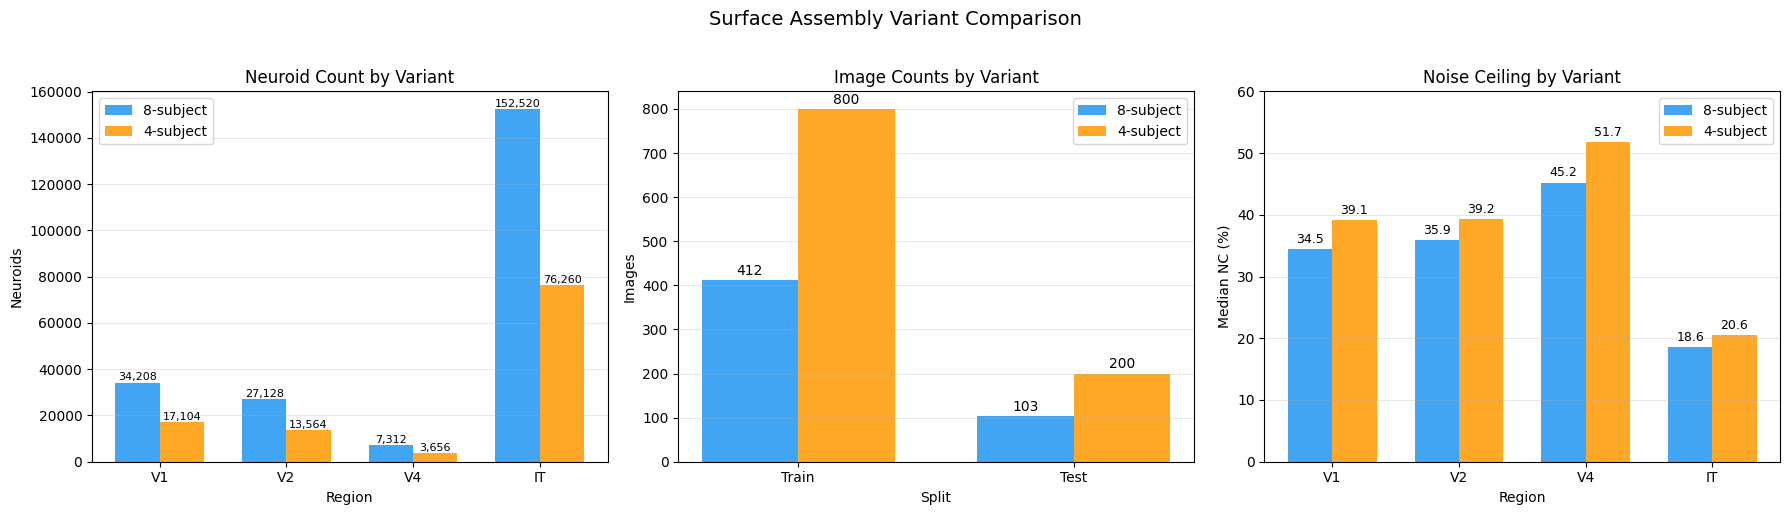

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

x = np.arange(len(REGIONS))
width = 0.35

# Panel 1: Neuroid counts
ax = axes[0]
c8 = [int((train_8s.coords['region'].values == r).sum()) for r in REGIONS]
c4 = [int((train_4s.coords['region'].values == r).sum()) for r in REGIONS]
bars1 = ax.bar(x - width/2, c8, width, label='8-subject', color='#2196F3', alpha=0.85)
bars2 = ax.bar(x + width/2, c4, width, label='4-subject', color='#FF9800', alpha=0.85)
ax.set_xlabel('Region')
ax.set_ylabel('Neuroids')
ax.set_title('Neuroid Count by Variant')
ax.set_xticks(x)
ax.set_xticklabels(REGIONS)
ax.legend()
ax.grid(axis='y', alpha=0.3)
for bar in bars1 + bars2:
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 100,
            f'{int(bar.get_height()):,}', ha='center', va='bottom', fontsize=8)

# Panel 2: Train/test image counts
ax = axes[1]
n_test_8 = len(set(assemblies['8-subject']['test'].coords['stimulus_id'].values))
n_test_4 = len(set(assemblies['4-subject']['test'].coords['stimulus_id'].values))
categories = ['Train', 'Test']
vals_8 = [train_8s.sizes['presentation'], n_test_8]
vals_4 = [train_4s.sizes['presentation'], n_test_4]
x2 = np.arange(len(categories))
bars1 = ax.bar(x2 - width/2, vals_8, width, label='8-subject', color='#2196F3', alpha=0.85)
bars2 = ax.bar(x2 + width/2, vals_4, width, label='4-subject', color='#FF9800', alpha=0.85)
ax.set_xlabel('Split')
ax.set_ylabel('Images')
ax.set_title('Image Counts by Variant')
ax.set_xticks(x2)
ax.set_xticklabels(categories)
ax.legend()
ax.grid(axis='y', alpha=0.3)
for bar in bars1 + bars2:
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 5,
            str(int(bar.get_height())), ha='center', va='bottom', fontsize=10)

# Panel 3: Median NC per region
ax = axes[2]
nc8 = [float(np.nanmedian(train_8s.coords['nc_testset'].values[
    train_8s.coords['region'].values == r])) for r in REGIONS]
nc4 = [float(np.nanmedian(train_4s.coords['nc_testset'].values[
    train_4s.coords['region'].values == r])) for r in REGIONS]
bars1 = ax.bar(x - width/2, nc8, width, label='8-subject', color='#2196F3', alpha=0.85)
bars2 = ax.bar(x + width/2, nc4, width, label='4-subject', color='#FF9800', alpha=0.85)
ax.set_xlabel('Region')
ax.set_ylabel('Median NC (%)')
ax.set_title('Noise Ceiling by Variant')
ax.set_xticks(x)
ax.set_xticklabels(REGIONS)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 60)
for bar in bars1 + bars2:
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
            f'{bar.get_height():.1f}', ha='center', va='bottom', fontsize=9)

fig.suptitle('Surface Assembly Variant Comparison', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

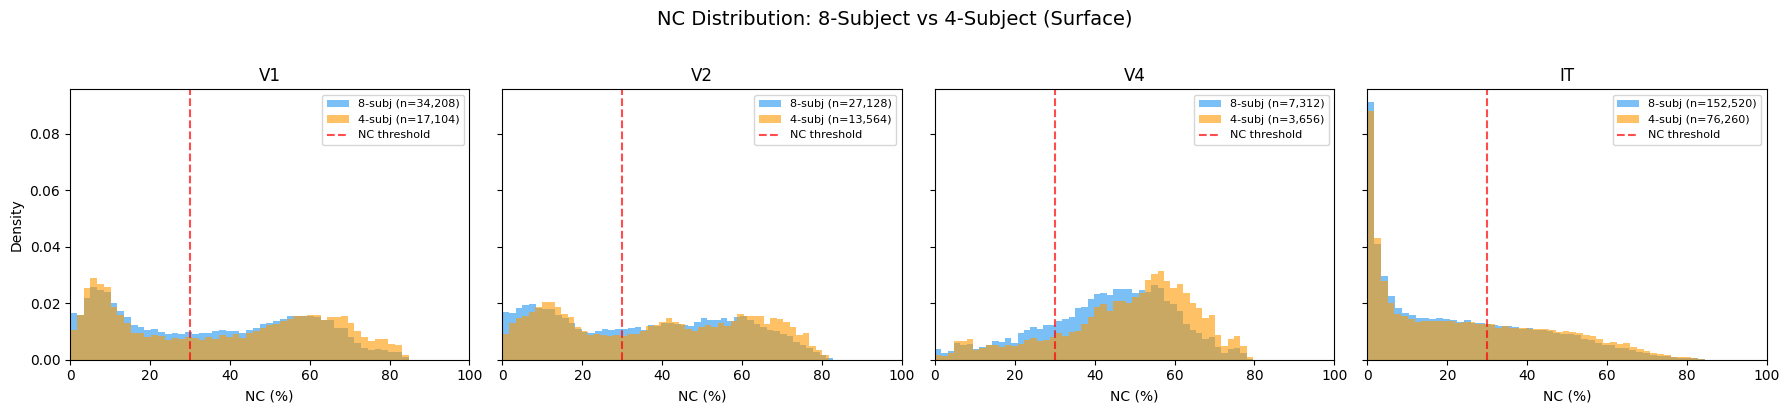

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(18, 4), sharey=True)

for i, region in enumerate(REGIONS):
    ax = axes[i]
    nc_8 = train_8s.coords['nc_testset'].values[
        train_8s.coords['region'].values == region]
    nc_4 = train_4s.coords['nc_testset'].values[
        train_4s.coords['region'].values == region]

    ax.hist(nc_8, bins=50, alpha=0.6, color='#2196F3',
            label=f'8-subj (n={len(nc_8):,})', density=True)
    ax.hist(nc_4, bins=50, alpha=0.6, color='#FF9800',
            label=f'4-subj (n={len(nc_4):,})', density=True)
    ax.axvline(x=30, color='red', linestyle='--', alpha=0.7, label='NC threshold')
    ax.set_title(region, fontsize=12)
    ax.set_xlabel('NC (%)')
    if i == 0:
        ax.set_ylabel('Density')
    ax.legend(fontsize=8)
    ax.set_xlim(0, 100)

fig.suptitle('NC Distribution: 8-Subject vs 4-Subject (Surface)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 6. Summary

In [11]:
print('Surface Benchmark Smoke Test Summary')
print('=' * 60)
print(f'Assemblies loaded: 8-subject and 4-subject')
print(f'  8-subject train: {assemblies["8-subject"]["train"].shape}')
print(f'  4-subject train: {assemblies["4-subject"]["train"].shape}')
print(f'Benchmarks scored: {len(results_df)} (2 variants x 4 regions x 2 metrics)')
print()

for label in ['8-subject', '4-subject']:
    subset = results_df[results_df['variant'] == label]
    print(f'{label} (ceiling-normalized):')
    print(f'  {"Region":>6s}  {"Ridge":>8s}  {"RDM":>8s}')
    for region in REGIONS:
        ridge_row = subset[(subset['region'] == region) & (subset['metric'] == 'ridge')]
        rdm_row = subset[(subset['region'] == region) & (subset['metric'] == 'rdm')]
        r_val = ridge_row['normalized'].values[0] if len(ridge_row) else float('nan')
        d_val = rdm_row['normalized'].values[0] if len(rdm_row) else float('nan')
        print(f'  {region:>6s}  {r_val:>8.4f}  {d_val:>8.4f}')
    print()

print('All checks passed.')

Surface Benchmark Smoke Test Summary
Assemblies loaded: 8-subject and 4-subject
  8-subject train: (412, 221168, 1)
  4-subject train: (800, 110584, 1)
Benchmarks scored: 16 (2 variants x 4 regions x 2 metrics)

8-subject (ceiling-normalized):
  Region     Ridge       RDM
      V1    0.4129    0.4501
      V2    0.4409    0.3790
      V4    0.4009    0.3713
      IT    0.2975    0.4036

4-subject (ceiling-normalized):
  Region     Ridge       RDM
      V1    0.4062    0.5637
      V2    0.4303    0.4632
      V4    0.3690    0.4768
      IT    0.2804    0.4280

All checks passed.


In [12]:
for label in assemblies:
    assemblies[label]['train'].close()
    assemblies[label]['test'].close()
print('All assemblies closed.')

All assemblies closed.
